In [1]:
import sys
[sys.path.append(i) for i in ['.', '..']]
import torch
import numpy as np
from mirtorch.alg.cg import CG
from mirtorch.linear import LinearMap, FFTCn, NuSense, Sense, FFTCn, Identity, Diff2dframe, Gmri, NuSenseFrame
import matplotlib.pyplot as plt
import copy
import h5py
import torchkbnufft as tkbn
import time
import os

%load_ext autoreload
%autoreload 2

## FFT example
First example shows the basic usage of linear operators.
You can use +, -, * like matrices, as long as the size matches.
.H calls the adjoint operatos.

In [2]:
# Assign device
device0 = torch.device('cuda:0')
# Load image
from skimage.data import shepp_logan_phantom
I_shepp = torch.tensor(shepp_logan_phantom()).to(device0)
# Define operator
Fop = FFTCn((400, 400), (400, 400), (0,1), norm = 'ortho')
k_shepp = Fop*I_shepp

show the k-space

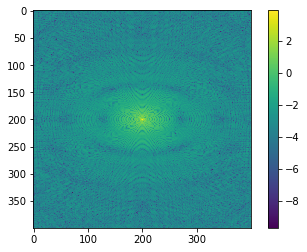

In [3]:
plt.imshow(torch.log(torch.abs(k_shepp)).cpu().data.numpy())
plt.colorbar()

## MRI parallel imaging example (SENSE)
Here we trys a 8-times equidistant 1d undersampling mask.
Both conjugate phase reconstruction (A'y)
and quadratic roughness least-squares reconstruction (argmin(x) \|Ax-y\|_2^2 + \lambda \|Rx\|_2^2) are shown.

kspace shape torch.Size([1, 16, 320, 320])
image shape torch.Size([1, 1, 320, 320])


Text(0.5, 1.0, 'Undersampled')

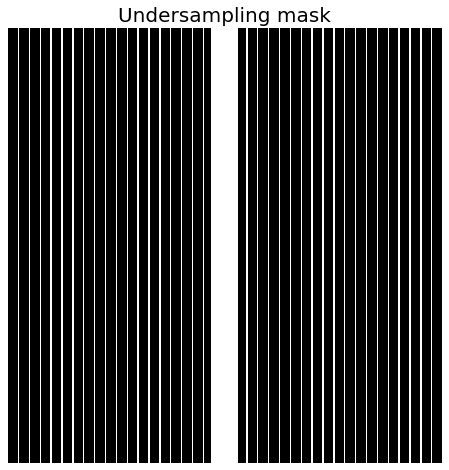

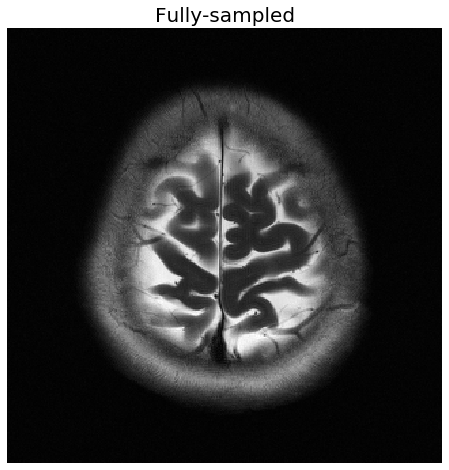

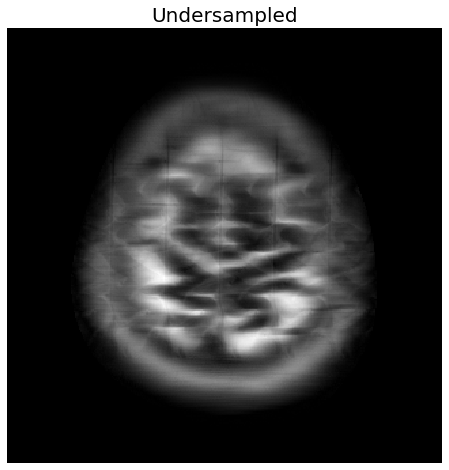

In [4]:
ex_multi = np.load('AXT2_210_6001736_layer11.npz')
device0 = torch.device('cuda:0')
# k-space
k_c = torch.tensor(ex_multi['k_r'] + 1j*ex_multi['k_i']).to(device0)/32767.0
# Sense map
s_c = torch.tensor(ex_multi['s_r'] + 1j*ex_multi['s_i']).to(device0)/32767.0
# Define Sense operator
(nc, nh, nw) = s_c.shape
Fop = FFTCn((nc, nh, nw), (nc, nh, nw), (1,2), norm = 'ortho')
# Conjugate phase reconstruction
I1 = (Fop.H*k_c).to(torch.complex64).to(device0).unsqueeze(0)
nx = 320
ny = 320
I1 = I1[:,:,nh//2-nx//2:nh//2+nx//2,nw//2-ny//2:nw//2+ny//2]
s_c = s_c[:,nh//2-nx//2:nh//2+nx//2,nw//2-ny//2:nw//2+ny//2].unsqueeze(0).to(torch.complex64).to(device0)
mask = torch.zeros(nx,ny).to(device0)
mask[:,0:ny:8]=1
mask[:,150:170]=1
# mask = torch.ones(nx,ny)

Fop = FFTCn((1, nc, nx, ny), (1, nc, nx, ny), (2,3), norm = 'ortho')
K1 = Fop*I1
Sop = Sense(s_c, mask.unsqueeze(0))
I0 = Sop.H*K1
print('kspace shape', K1.shape)
print('image shape', I0.shape)



plt.figure(figsize=(8,8))
plt.imshow(mask.cpu(), cmap = 'gray')
plt.axis('off')
plt.title('Undersampling mask',size = 20)


plt.figure(figsize=(8,8))
plt.imshow(torch.flip(torch.sqrt(torch.sum(torch.square(I1[0].abs()),dim=0)),[0,1]).cpu().data.numpy(), cmap = 'gray')
plt.axis('off')
plt.title('Fully-sampled',size = 20)



plt.figure(figsize=(8,8))
plt.imshow(torch.flip(torch.abs(I0[0,0,:,:]),[0,1]).cpu().data.numpy(), cmap = 'gray')
plt.axis('off')
plt.title('Undersampled',size = 20)

Define the quadratic roughness penalty, and corresponding CG reconstruction.

In [5]:
T = Diff2dframe(Sop.size_in)
CG_tik = CG(Sop.H*Sop+0.001*T, max_iter = 20, tol=1e-2, alert = False)

0.029071331024169922


Text(0.5, 1.0, 'Reconsturction: QPLS')

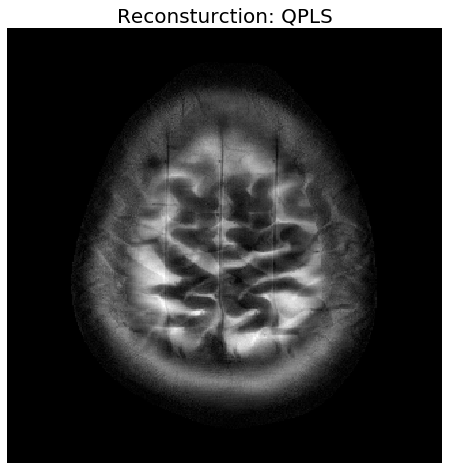

In [6]:
# I0 is both the initialization, and the b in Ax = b.
start = time.time()
I_tik = CG_tik.run(I0, I0)
print(time.time()-start)
plt.figure(figsize=(8,8))
plt.imshow(torch.flip(torch.abs(I_tik[0,0,:,:]),[0,1]).cpu().data.numpy(), cmap = 'gray')
# plt.colorbar()
plt.axis('off')
plt.title('Reconsturction: QPLS',size = 20)

Text(0.5, 1.0, 'Undersampled')

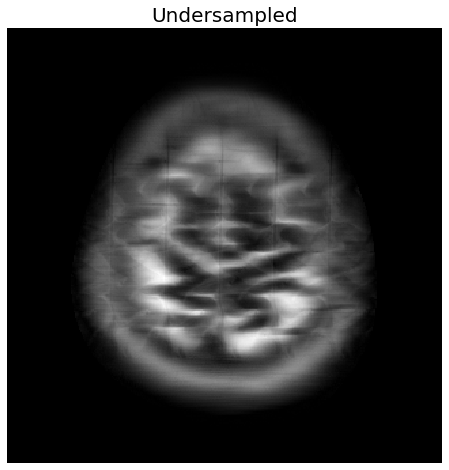

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(torch.flip(torch.abs(I0[0,0,:,:]),[0,1]).cpu().data.numpy(), cmap = 'gray')
plt.axis('off')
plt.title('Undersampled',size = 20)

## Non-Cartesian reconstruction
Here we test a non-Cartesian reconstruction cases.

In [8]:
# Download the files
if not os.path.exists('./b0.h5'):
    import wget
    url = "https://www.dropbox.com/s/q1cr3u1yyvzjtoj/b0.h5?dl=1"
    wget.download(url, './b0.h5')

In [9]:
hf = h5py.File('./b0.h5', 'r')
nx = 320;
ny = 320;
# Load Non-cartesian k-space trajectory
ktraj = hf['ktraj'][()]
ktraj = np.remainder(ktraj + np.pi, 2*np.pi)-np.pi
print('traj shape', ktraj.shape)
# Load k-space
k = hf['k_r'][()] + 1j*hf['k_i'][()]
[ncoil, nslice, nshot, ns] = k.shape
print('k shape', k.shape)
# Load density compensation function
dcf = hf['dcf'][()]
print('dcf shape', dcf.shape)
# Load sensetivity maps
smap = np.transpose(hf['s_r'][()] + 1j*hf['s_i'][()], (3,0,1,2))
smap = np.transpose(smap, (0,1,3,2))
[_, _, nx, ny] = smap.shape
print('smap shape', smap.shape)
# Load fmaps
fmap = hf['b0'][()]
fmap = np.transpose(fmap, (0,2,1))
print('fmap shape', fmap.shape)
# Define 5x retrospective undersampling mask
ktrajunder = ktraj.reshape(2,320,1280)
ktrajunder = ktrajunder[:,0:-1:5,:].reshape(2,81920)
kunder = k[:,:,0:-1:5,:]

traj shape (2, 409600)
k shape (32, 15, 320, 1280)
dcf shape (1, 409600)
smap shape (15, 32, 320, 320)
fmap shape (15, 320, 320)


In [10]:
# Load the numpy file to the pytorch, and define the operator
im_size = (nx,ny)
iz = 6
device0 = torch.device('cuda:0')
k0 = torch.tensor(kunder[:,iz,:,:]).to(device = device0).reshape(1,ncoil,nshot*ns//5)
k1 = torch.tensor(k[:,iz,:,:]).to(device = device0).reshape(1,ncoil,nshot*ns)
s0 = torch.tensor(smap[iz,:,:,:]).to(device = device0).unsqueeze(0)
traj0 = torch.tensor(ktrajunder).to(device = device0)
traj1 = torch.tensor(ktraj).to(device = device0)

In [11]:
# Define field-corrected NuSENSE operator
b0 = torch.tensor(fmap[iz,:,:]).to(device0).unsqueeze(0)
Gop = Gmri(smaps=s0, zmap = -b0, traj = traj1.reshape(2, nshot, ns).unsqueeze(0))
Ib0 = Gop.H*k1.reshape(1,ncoil,nshot,ns)
T = Diff2dframe(Gop.size_in)
CG_FD_b0 = CG(Gop.H*Gop+0.0001*T, max_iter = 20)
I_FD_b0 = CG_FD_b0.run(Ib0, Ib0)

/home/guanhuaw/anaconda3/envs/torch/lib/python3.7/site-packages/torch/_tensor.py:579: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(other, self)


Text(0.5, 1.0, 'Fully-sampled (B0-correction)')

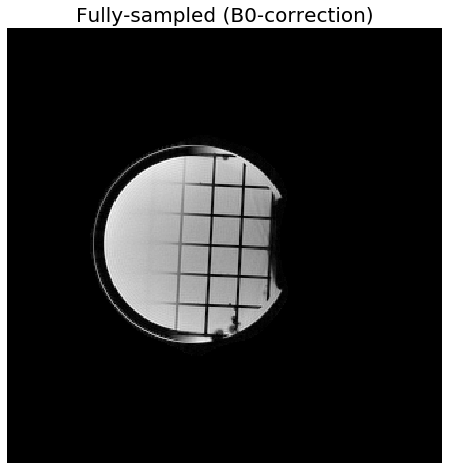

In [12]:
plt.figure(figsize=(8,8))
plt.imshow(torch.abs(I_FD_b0[0,0]).cpu().data.numpy(),cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('Fully-sampled (B0-correction)', size = 20)

In [13]:
# QPLS reconstruction
Nop = NuSense(s0, traj1)
Nopframe = NuSenseFrame(s0, traj1)
I0 = Nop.H*k1
T = Identity(Nop.size_in)
CG_FD = CG(Nopframe+0.0001*T, max_iter = 20)
start = time.time()
I_FD = CG_FD.run(I0, I0)
print(time.time()-start)

0.8021626472473145


Text(0.5, 1.0, 'Fully-sampled (w/o B0-correction)')

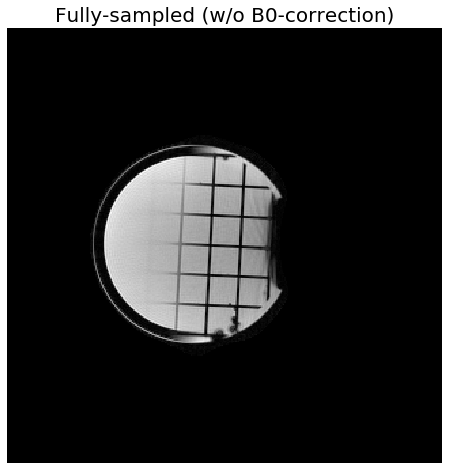

In [14]:
plt.figure(figsize=(8,8))
plt.imshow(torch.abs(I_FD[0,0,:,:].squeeze(0).squeeze(0)).cpu().data.numpy(),cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('Fully-sampled (w/o B0-correction)', size = 20)

In [ ]:
# QPLS reconstruction
Nop = NuSense(s0, traj0)
Nopframe = NuSenseFrame(s0, traj0)
I0 = Nop.H*k0
# T = Diff2dframe(Nop.size_in)
T = Identity(Nop.size_in)
CG_FD = CG(Nopframe+0.0001*T, max_iter=40)
I_FD = CG_FD.run(I0, I0)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(torch.abs(I_FD[0,0,:,:].squeeze(0).squeeze(0)).cpu().data.numpy(),cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('Reconstruction: QPLS (w/o B0-correction)', size = 20)

In [ ]:
# Define field-corrected NuSENSE operator
b0 = torch.tensor(fmap[iz,:,:]).to(device0).unsqueeze(0)
Gop = Gmri(smaps=s0, zmap = -b0, traj = traj0.reshape(2,nshot//5, ns).unsqueeze(0))

In [ ]:
Ib0 = Gop.H*k0.reshape(1,ncoil,nshot//5,ns)
T = Diff2dframe(Gop.size_in)
CG_FD_b0 = CG(Gop.H*Gop+0.0001*T, max_iter = 40)
I_FD_b0 = CG_FD_b0.run(Ib0, Ib0)

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(torch.abs(I_FD_b0[0,0]).cpu().data.numpy(),cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('Reconstruction: QPLS (B0-correction)', size = 20)

Text(0.5, 1.0, 'Reconstruction: QPLS (w/o B0-correction)')

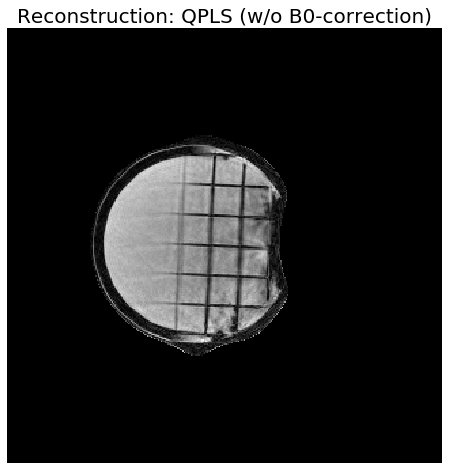

In [16]:
plt.figure(figsize=(8,8))
plt.imshow(torch.abs(I_FD[0,0,:,:].squeeze(0).squeeze(0)).cpu().data.numpy(),cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('Reconstruction: QPLS (w/o B0-correction)', size = 20)

In [17]:
# Define field-corrected NuSENSE operator
b0 = torch.tensor(fmap[iz,:,:]).to(device0).unsqueeze(0)
Gop = Gmri(smaps=s0, zmap = -b0, traj = traj0.reshape(2,nshot//5, ns).unsqueeze(0))

In [18]:
Ib0 = Gop.H*k0.reshape(1,ncoil,nshot//5,ns)
T = Diff2dframe(Gop.size_in)
CG_FD_b0 = CG(Gop.H*Gop+0.0001*T, max_iter = 40)
I_FD_b0 = CG_FD_b0.run(Ib0, Ib0)

Text(0.5, 1.0, 'Reconstruction: QPLS (B0-correction)')

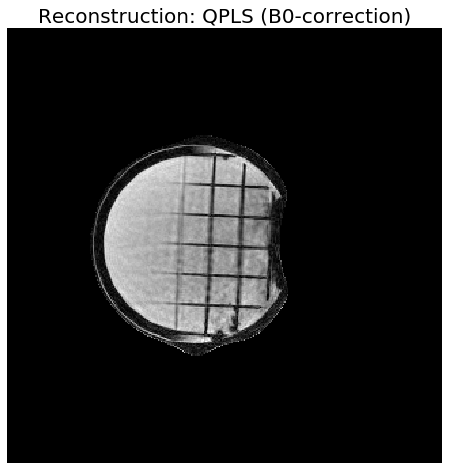

In [19]:
plt.figure(figsize=(8,8))
plt.imshow(torch.abs(I_FD_b0[0,0]).cpu().data.numpy(),cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('Reconstruction: QPLS (B0-correction)', size = 20)